In [6]:
import numpy as np
import pandas as pd
import math as m
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from scipy import *
import scipy.linalg
import torch
from torch import nn, optim
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.datasets import make_swiss_roll
from sklearn.preprocessing import MinMaxScaler


import scaleogram as scg
import matplotlib.pyplot as plt
import warnings

from visuals import *
from my_lib import *
from SSA_lib import SSA

In [78]:
warnings.simplefilter('ignore')

plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 8

In [8]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
dt = 459*10
#data = pd.read_csv('data/long_walk_100_acc.csv', delimiter =';', decimal=',')[3815+6*455:3815+6*455+dt]
data = pd.read_csv('data/long_walk_100_acc.csv', delimiter =';', decimal=',')[7009:7009+dt]
#data = pd.read_csv('data/long_walk_100_acc.csv', delimiter =';', decimal=',')[3785:8000]
#data = pd.read_csv('data/home_lin_10_lac.csv', delimiter =';', decimal=',')[:]
frecuency = len(data)/(data['time'].values[-1]-data['time'].values[0])
assert 480 < frecuency < 520

x_acc = ( (data['X_value'].values)**2 + (data['Y_value'].values)**2 + (data['Z_value'].values)**2)**.5
_m = np.mean(x_acc)
x_acc -= _m
t = (data['time'].values).astype(float).reshape([-1,])
t = np.linspace(0,t[-1]-t[0],len(x_acc))

fig = go.Figure()
fig.add_scatter(y = x_acc, mode='lines', name='Sum squares')
fig.show()

In [10]:
accel_ssa = SSA(x_acc, 500)

x_acc_clear = accel_ssa.reconstruct(slice(0,5))

def HankelMatrix(X, L):  
    N = X.shape[0]
    return scipy.linalg.hankel(X[ : N - L + 1], X[N - L : N])

In [164]:
track2, basis2 = phase_track(np.array([x_acc_clear]).T, 500, 3)
plot_phase_track(track2)

Explained variation for 3 principal components: [0.40452378 0.35770145 0.12109012]
Cumulative explained variationfor 3 principal components: 0.8833153475255677



In [165]:
X = HankelMatrix(x_acc_clear,500)
x = torch.from_numpy(X).to(device)

In [13]:
class Autoencoder(nn.Module):
    """Makes the main denoising auto

    Parameters
    ----------
    in_shape [int] : input shape
    enc_shape [int] : desired encoded shape
    """

    def __init__(self, in_shape, enc_shape):
        super(Autoencoder, self).__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(in_shape, 512),
            nn.ReLU(True),
            nn.Dropout(0.2),
            
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Dropout(0.2),
            
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Dropout(0.2),
            
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Dropout(0.2),
            
            nn.Linear(64, enc_shape),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(enc_shape, 64),
            nn.ReLU(True),
            nn.Dropout(0.2),
            
            nn.Linear(64, 128),
            nn.ReLU(True),
            
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Dropout(0.2),
            
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Dropout(0.2),
            
            nn.Linear(512, in_shape)
        )
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [166]:
class Autoencoder(nn.Module):
    """Makes the main denoising auto

    Parameters
    ----------
    in_shape [int] : input shape
    enc_shape [int] : desired encoded shape
    """

    def __init__(self, in_shape, enc_shape):
        super(Autoencoder, self).__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(in_shape, 512),
            nn.ReLU(True),
            
            nn.Linear(512, 256),
            nn.ReLU(True),
            
            nn.Linear(256, 128),
            nn.ReLU(True),
            
            nn.Linear(128, 64),
            nn.ReLU(True),
            
            nn.Linear(64, enc_shape),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(enc_shape, 64),
            nn.ReLU(True),
            
            nn.Linear(64, 128),
            nn.ReLU(True),
            
            nn.Linear(128, 256),
            nn.ReLU(True),
            
            nn.Linear(256, 512),
            nn.ReLU(True),
            
            nn.Linear(512, in_shape)
        )
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [167]:
encoder = Autoencoder(in_shape=500, enc_shape=3).double().to(device)

error = nn.MSELoss()

optimizer = optim.Adam(encoder.parameters())

def train(model, error, optimizer, n_epochs, x):
    model.train()
    for epoch in range(1, n_epochs + 1):
        optimizer.zero_grad()
        output = model(x)
        loss = error(output, x)
        loss.backward()
        optimizer.step()
        
        if epoch % int(0.1*n_epochs) == 0:
            print(f'epoch {epoch} \t Loss: {loss.item():.4g}')

In [168]:
train(encoder, error, optimizer, 1500, x)

epoch 150 	 Loss: 0.4054
epoch 300 	 Loss: 0.1725
epoch 450 	 Loss: 0.1634
epoch 600 	 Loss: 0.1223
epoch 750 	 Loss: 0.04184
epoch 900 	 Loss: 0.111
epoch 1050 	 Loss: 0.03936
epoch 1200 	 Loss: 0.1229
epoch 1350 	 Loss: 0.03495
epoch 1500 	 Loss: 0.03302


In [169]:
with torch.no_grad():
    encoded = encoder.encode(x)
    decoded = encoder.decode(encoded)
    mse = error(decoded, x).item()
    enc = encoded.cpu().detach().numpy()
    dec = decoded.cpu().detach().numpy()

In [171]:
fig_2 = go.Figure()


fig_2.add_trace(go.Scatter3d(x=enc[:,0][::],
                             y=enc[:,1][::],
                             z=enc[:,2][::],
                             #mode='markers',
                             marker=dict(
                                         size=0.1,
                                         line=dict(
                                                    width=0.01
                                                  )

                                         ),
                             name='trajectory'
                            )
                )


fig_2.layout.template = 'plotly_white'
fig_2.show()

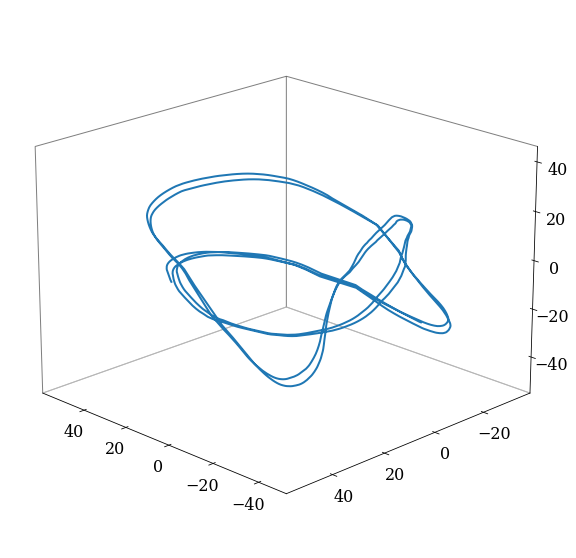

In [172]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(enc[:1000,0], enc[:1000,1], enc[:1000,2])

ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
#ax.set_zlim(contourz,X_PCA[:,2].max()*1.1)
ax.view_init(elev=20, azim=135)

ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


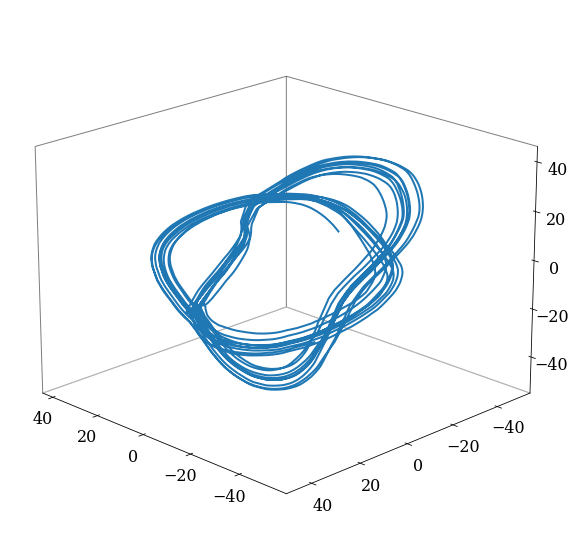

In [193]:
a = -120/180 * np.pi

T_X = np.array([[1,0,0],
                [0,np.cos(a),-np.sin(a)],
                [0,np.sin(a),np.cos(a)]])

T_Y = np.array([[np.cos(a),-np.sin(a),0],
                [np.sin(a),np.cos(a),0],
                [0,0,1]])

T_Z = np.array([[np.cos(a),0,np.sin(a)],
                [0,1,0],
                [-np.sin(a),0,np.cos(a)]])

enc_T = enc@T_Y

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(enc_T[:,0], enc_T[:,1], enc_T[:,2])

ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
#ax.set_zlim(contourz,X_PCA[:,2].max()*1.1)
ax.view_init(elev=20, azim=135)

ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
fig.savefig('/Users/denistikhonov/Desktop/Study/IAD'
            +'/Research_work/Spherical_Harmonics_parametrisation/doc/figs/phase_enc.eps',
            format='eps',
            dpi=600)
plt.show()

In [194]:
Sphere_projection(enc, n = 1)